In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/HAM10000_folders/mel/ISIC_0028582.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0027742.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0030032.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0031479.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0033624.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0033152.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0031417.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0025611.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0026352.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0026239.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0033239.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0028075.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0028520.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0033878.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0027100.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0029056.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0031005.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0030970.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0032987.jpg
/kaggle/inpu


# **Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
import cv2
import tensorflow as tf

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **DATA Preprocessing**

In [3]:
lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions',
    'mel': 'Melanoma'
}

base_skin_dir = '/kaggle/input/HAM10000_folders'

# **Merge images from both folders into one dictionary**

In [4]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# image_id → folder/label (short code)
imageid_label_dict = {os.path.splitext(os.path.basename(x))[0]: os.path.basename(os.path.dirname(x))
                      for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# -------------------------------
# Create DataFrame
# -------------------------------
df = pd.DataFrame({
    'image_id': list(imageid_path_dict.keys()),
    'file_path': list(imageid_path_dict.values()),
    'label': [imageid_label_dict[i] for i in imageid_path_dict.keys()]
})

# Map label (short code) to full lesion type name
df['lesion_type'] = df['label'].map(lesion_type_dict)

# Shuffle dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check
print(df.head())
print(df['label'].value_counts())

       image_id                                          file_path label  \
0  ISIC_0025300  /kaggle/input/HAM10000_folders/nv/ISIC_0025300...    nv   
1  ISIC_0028503  /kaggle/input/HAM10000_folders/bkl/ISIC_002850...   bkl   
2  ISIC_0026937  /kaggle/input/HAM10000_folders/nv/ISIC_0026937...    nv   
3  ISIC_0032645  /kaggle/input/HAM10000_folders/mel/ISIC_003264...   mel   
4  ISIC_0028547  /kaggle/input/HAM10000_folders/nv/ISIC_0028547...    nv   

                     lesion_type  
0               Melanocytic nevi  
1  Benign keratosis-like lesions  
2               Melanocytic nevi  
3                       Melanoma  
4               Melanocytic nevi  
label
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


⚙️ Preprocessing all images...


100%|██████████| 10015/10015 [02:12<00:00, 75.53it/s]


✅ Preprocessing complete. All images saved to: /kaggle/working/preprocessed_images


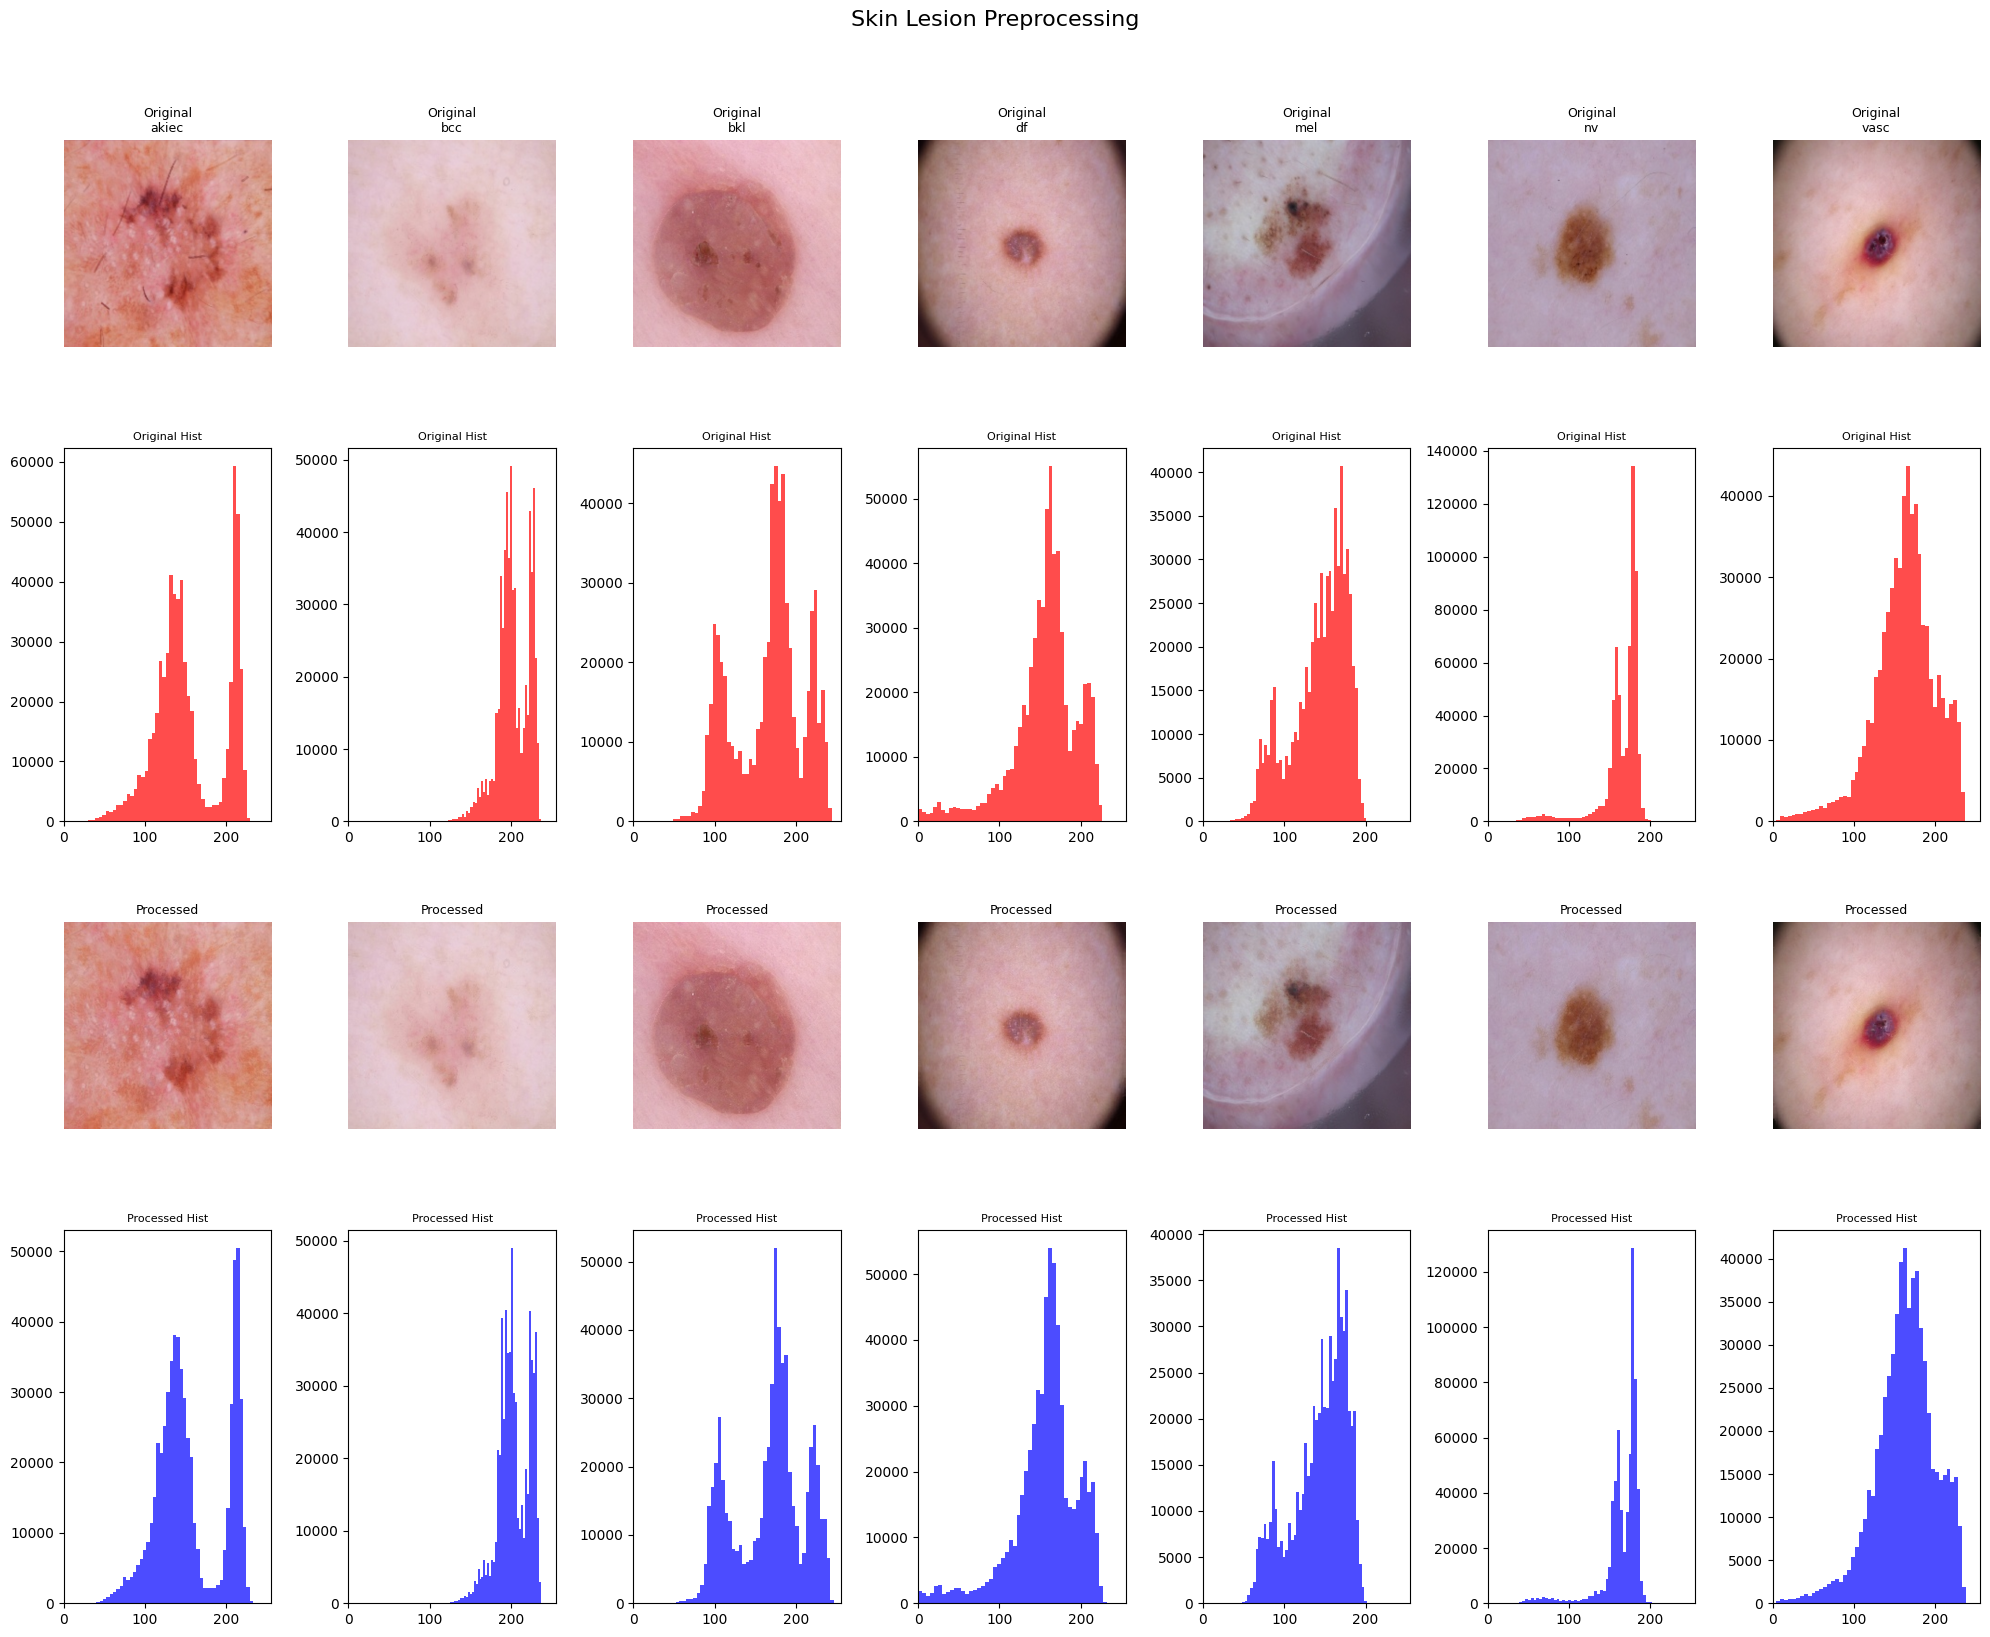

In [5]:
from tqdm import tqdm

# -------------------------
# Preprocessing function
# -------------------------
def preprocess(input_img, IMAGE_SIZE=456):
    """
    Preprocess skin lesion images:
    - Hair removal
    - Resize to IMAGE_SIZE
    """
    if isinstance(input_img, str):
        img = cv2.imread(input_img)
        if img is None:
            raise FileNotFoundError(f"Could not read image: {input_img}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = input_img
        if img.dtype != np.uint8:
            img = img.astype(np.uint8)

    # Hair removal
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (11, 11))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, hair_mask = cv2.threshold(blackhat, 15, 255, cv2.THRESH_BINARY)
    cleaned = cv2.inpaint(img, hair_mask, 1, cv2.INPAINT_TELEA)

    # Resize
    cleaned_resized = cv2.resize(cleaned, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LANCZOS4)
    return cleaned_resized

# -------------------------
# Step 1: Preprocess all images
# -------------------------
output_dir = "/kaggle/working/preprocessed_images"
os.makedirs(output_dir, exist_ok=True)

processed_paths = []

print("⚙️ Preprocessing all images...")
for row in tqdm(df.itertuples(), total=len(df)):
    processed = preprocess(row.file_path)
    
    filename = os.path.basename(row.file_path)
    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))  # save in BGR
    
    processed_paths.append(save_path)

df["processed_path"] = processed_paths
print("✅ Preprocessing complete. All images saved to:", output_dir)

# -------------------------
# Step 2: Visualization (7 samples, one per class)
# -------------------------
sample_images = df.groupby('label').first().reset_index()
num_classes = len(sample_images)

plt.figure(figsize=(20, 16))

for i, row in enumerate(sample_images.itertuples(), 1):
    # Original
    original = cv2.imread(row.file_path)
    original = cv2.cvtColor(cv2.resize(original, (456, 456)), cv2.COLOR_BGR2RGB)
    
    # Processed
    processed = cv2.imread(row.processed_path)
    processed = cv2.cvtColor(cv2.resize(processed, (456, 456)), cv2.COLOR_BGR2RGB)
    
    # Plot Original Image
    plt.subplot(4, num_classes, i)
    plt.imshow(original)
    plt.title(f"Original\n{row.label}", fontsize=9)
    plt.axis('off')
    
    # Original Histogram
    plt.subplot(4, num_classes, i + num_classes)
    plt.hist(original.ravel(), bins=50, color='red', alpha=0.7)
    plt.title("Original Hist", fontsize=8)
    plt.xlim(0, 255)
    
    # Processed Image
    plt.subplot(4, num_classes, i + 2*num_classes)
    plt.imshow(processed)
    plt.title("Processed", fontsize=9)
    plt.axis('off')
    
    # Processed Histogram
    plt.subplot(4, num_classes, i + 3*num_classes)
    plt.hist(processed.ravel(), bins=50, color='blue', alpha=0.7)
    plt.title("Processed Hist", fontsize=8)
    plt.xlim(0, 255)

plt.tight_layout()
plt.suptitle("Skin Lesion Preprocessing", y=1.02, fontsize=16)
plt.show()


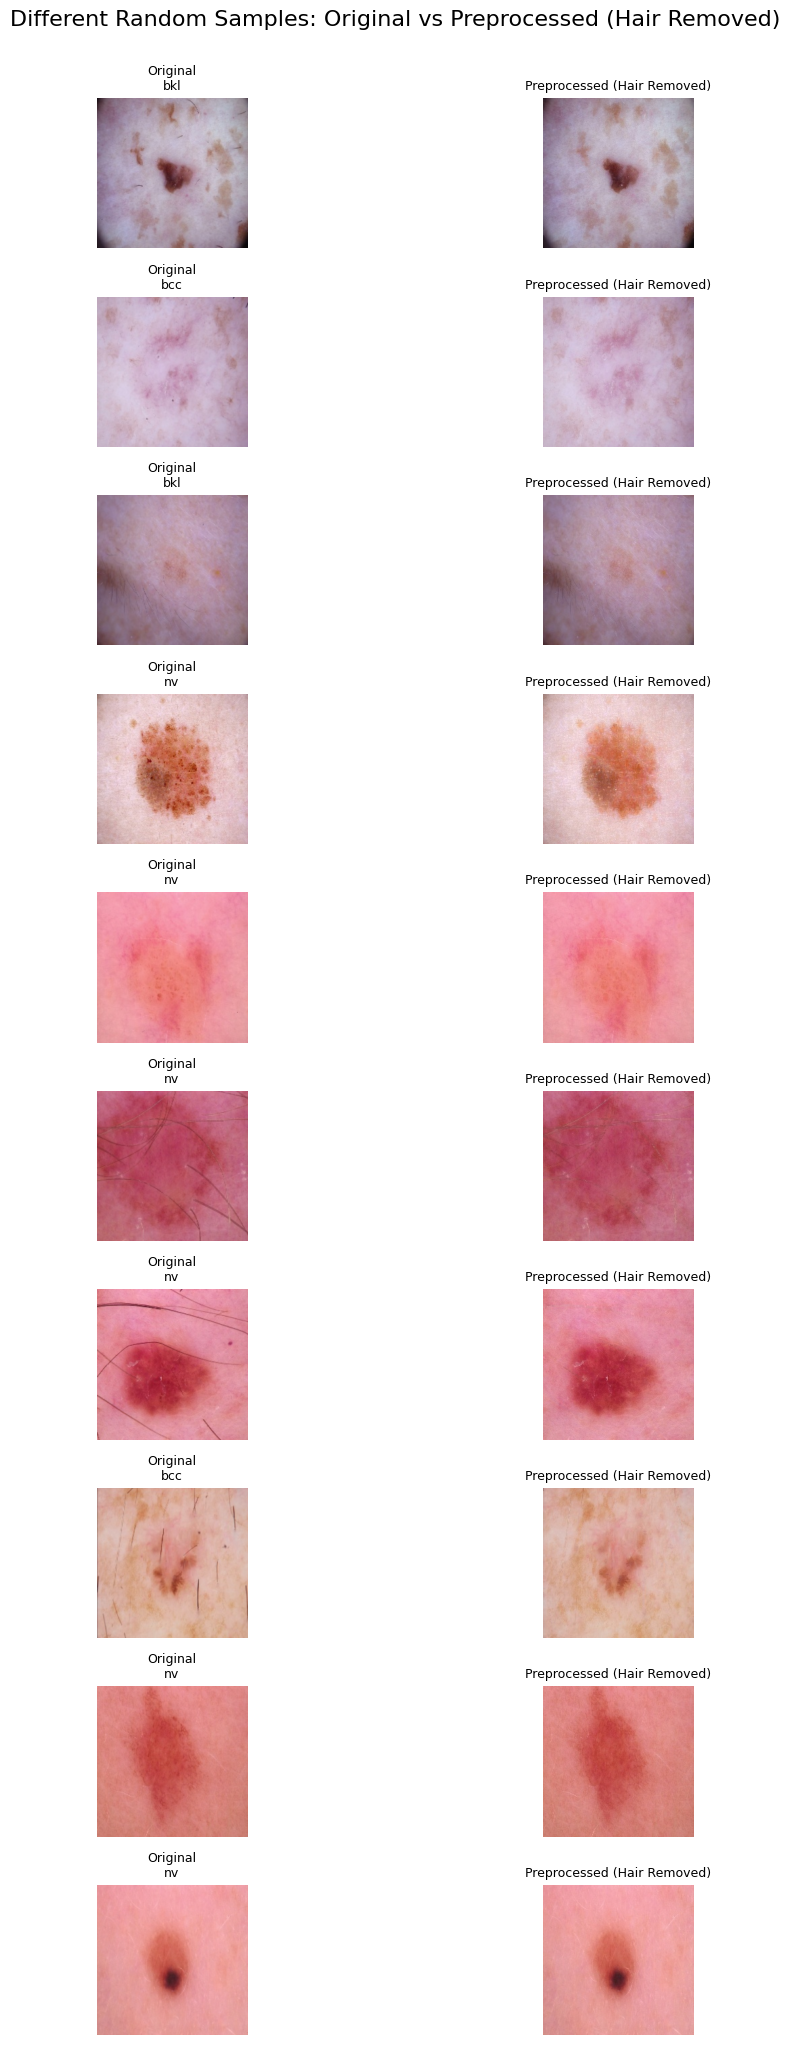

In [6]:
np.random.seed(123)  # Different from the previous seed (42)

# -------------------------
# Show 10 different random samples (Original vs Preprocessed)
# -------------------------

# Pick different random samples
n_samples = min(10, len(df))
sampled_df = df.sample(n=n_samples, random_state=123)  # Different seed

plt.figure(figsize=(12, n_samples * 2))

for idx, row in enumerate(sampled_df.itertuples()):
    # Read Original
    original = cv2.imread(row.file_path)
    original = cv2.cvtColor(cv2.resize(original, (456, 456)), cv2.COLOR_BGR2RGB)

    # Read Preprocessed
    processed = cv2.imread(row.processed_path)
    processed = cv2.cvtColor(cv2.resize(processed, (456, 456)), cv2.COLOR_BGR2RGB)

    # Plot Original
    plt.subplot(n_samples, 2, idx * 2 + 1)
    plt.imshow(original)
    plt.axis("off")
    plt.title(f"Original\n{row.label}", fontsize=9)

    # Plot Preprocessed
    plt.subplot(n_samples, 2, idx * 2 + 2)
    plt.imshow(processed)
    plt.axis("off")
    plt.title("Preprocessed (Hair Removed)", fontsize=9)

plt.tight_layout()
plt.suptitle("Different Random Samples: Original vs Preprocessed (Hair Removed)", y=1.02, fontsize=16)
plt.show()

# **Frequency Distribution of Classes**

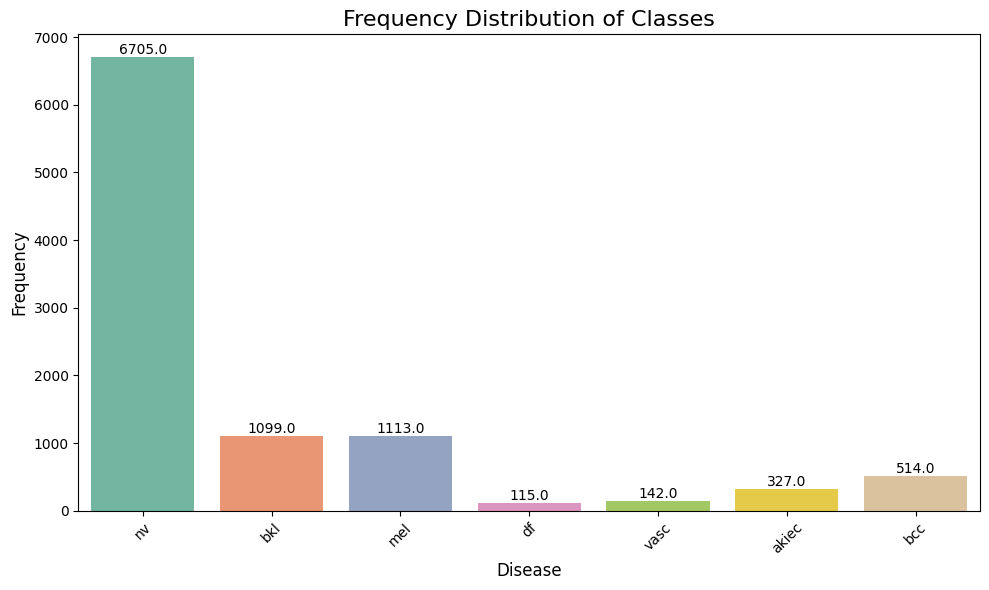

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use the correct DataFrame and column name
plt.figure(figsize=(10,6))
ax = sns.countplot(x='label', data=df, palette='Set2')  # replace 'label' with 'dx' if needed

plt.xlabel('Disease', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency Distribution of Classes', fontsize=16)
plt.xticks(rotation=45)

# Annotate counts on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# **Data Splitting**

In [8]:
from sklearn.model_selection import train_test_split

# Use correct column names
X = df['file_path'].values      # image paths
y = df['label'].values          # class labels (short codes)

# 1. Split 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# 2. Split temp into 10% val and 20% test (relative to original)
# temp is 30% of original, so to get val=10% and test=20% we split temp as 1/3 val, 2/3 test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42)

# Check sizes
print(f"Train size: {len(X_train)} ({len(X_train)/len(X):.2%})")
print(f"Validation size: {len(X_val)} ({len(X_val)/len(X):.2%})")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X):.2%})")


Train size: 7010 (70.00%)
Validation size: 1001 (10.00%)
Test size: 2004 (20.01%)


# **Combine into DataFrames**

In [9]:
train_df = pd.DataFrame({'path': X_train, 'label': y_train})
val_df   = pd.DataFrame({'path': X_val,   'label': y_val})
test_df  = pd.DataFrame({'path': X_test,  'label': y_test})

# Convert labels to string for generators
for d in [train_df, val_df, test_df]:
    d['label'] = d['label'].astype(str)

# -------------------
# Map to preprocessed path
# -------------------
preprocessed_dir = "/kaggle/working/preprocessed_images"

for d in [train_df, val_df, test_df]:
    d['processed_path'] = d['path'].apply(lambda x: os.path.join(preprocessed_dir, os.path.basename(x)))

# ✅ Now use `processed_path` column for your generators
print("Example preprocessed path:", train_df['processed_path'].iloc[0])

# ✅ Show number of images in each class
print("\nNumber of images per class (Training Set):")
print(train_df['label'].value_counts())

print("\nNumber of images per class (Validation Set):")
print(val_df['label'].value_counts())

print("\nNumber of images per class (Test Set):")
print(test_df['label'].value_counts())


Example preprocessed path: /kaggle/working/preprocessed_images/ISIC_0032050.jpg

Number of images per class (Training Set):
label
nv       4693
mel       779
bkl       769
bcc       360
akiec     229
vasc       99
df         81
Name: count, dtype: int64

Number of images per class (Validation Set):
label
nv       670
mel      111
bkl      110
bcc       51
akiec     33
vasc      14
df        12
Name: count, dtype: int64

Number of images per class (Test Set):
label
nv       1342
mel       223
bkl       220
bcc       103
akiec      65
vasc       29
df         22
Name: count, dtype: int64


# **Augmentation**

In [10]:
class_counts = train_df['label'].value_counts()
max_count = class_counts.max()
print("Original class distribution:\n", class_counts)

Original class distribution:
 label
nv       4693
mel       779
bkl       769
bcc       360
akiec     229
vasc       99
df         81
Name: count, dtype: int64


In [11]:
import os, cv2, shutil, random, numpy as np, pandas as pd

IMG_SIZE = 456
TARGET_COUNT = 1000
balanced_dir = "/kaggle/working/balanced_train_safe"
os.makedirs(balanced_dir, exist_ok=True)

class_counts = train_df['label'].value_counts()
print("Original class distribution:\n", class_counts, "\n")

balanced_paths, balanced_labels = [], []

# --- Safe augmentations ---
def resize_img(img):
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

def rotate_image(image, angle):
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

def flip_image(image, mode="h"):
    if mode == "h": return cv2.flip(image, 1)
    elif mode == "v": return cv2.flip(image, 0)
    elif mode == "hv": return cv2.flip(image, -1)
    return image

def zoom_image(image, factor=1.1):
    h, w = image.shape[:2]
    nh, nw = int(h * factor), int(w * factor)
    resized = cv2.resize(image, (nw, nh))
    if factor > 1:
        startx = nw//2 - w//2
        starty = nh//2 - h//2
        cropped = resized[starty:starty+h, startx:startx+w]
    else:
        pad_x = (w - nw)//2
        pad_y = (h - nh)//2
        cropped = cv2.copyMakeBorder(resized, pad_y, h - nh - pad_y,
                                     pad_x, w - nw - pad_x, cv2.BORDER_REFLECT_101)
    return cropped

def add_noise(image, sigma=5):
    noise = np.random.normal(0, sigma, image.shape).astype(np.int16)
    noisy = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return noisy

def random_crop(image, crop_ratio=0.9):
    h, w = image.shape[:2]
    ch, cw = int(h * crop_ratio), int(w * crop_ratio)
    sy = random.randint(0, h - ch)
    sx = random.randint(0, w - cw)
    return image[sy:sy+ch, sx:sx+cw]

# --- Augmentation list (safe only) ---
augmentations = [
    ("rot", lambda img: rotate_image(img, random.choice([15, -15, 30, -30]))),
    ("flip", lambda img: flip_image(img, random.choice(["h", "v", "hv"]))),
    ("zoom", lambda img: zoom_image(img, random.uniform(0.9, 1.1))),
    ("crop", lambda img: random_crop(img, random.uniform(0.88, 0.95))),
    ("noise", lambda img: add_noise(img, sigma=random.randint(3, 8)))
]

def apply_random_augmentation(img):
    aug_name, aug_fn = random.choice(augmentations)
    aug_img = aug_fn(img)
    return resize_img(aug_img), aug_name

# --- Balance each class to 1000 ---
for label, count in class_counts.items():
    class_paths = train_df[train_df['label'] == label]['processed_path'].values
    class_dir = os.path.join(balanced_dir, label)
    os.makedirs(class_dir, exist_ok=True)

    # ---- UNDERSAMPLE if class has more than TARGET_COUNT ----
    if count > TARGET_COUNT:
        selected_paths = random.sample(list(class_paths), TARGET_COUNT)
        print(f"Class {label}: Undersampled from {count} → {len(selected_paths)}")
        for img_path in selected_paths:
            fname = os.path.basename(img_path)
            dst = os.path.join(class_dir, fname)
            shutil.copy(img_path, dst)
            balanced_paths.append(dst)
            balanced_labels.append(label)

    # ---- Copy & AUGMENT if class has fewer than TARGET_COUNT ----
    else:
        for img_path in class_paths:
            fname = os.path.basename(img_path)
            dst = os.path.join(class_dir, fname)
            shutil.copy(img_path, dst)
            balanced_paths.append(dst)
            balanced_labels.append(label)

        if count < TARGET_COUNT:
            n_needed = TARGET_COUNT - count
            print(f"Class {label}: Need {n_needed} augmentations")

            for _ in range(n_needed):
                src_path = random.choice(class_paths)
                img = cv2.imread(src_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                aug_img, aug_name = apply_random_augmentation(img)
                out_name = f"{os.path.splitext(os.path.basename(src_path))[0]}_{aug_name}_{random.randint(1000,9999)}.jpg"
                out_path = os.path.join(class_dir, out_name)
                cv2.imwrite(out_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
                balanced_paths.append(out_path)
                balanced_labels.append(label)

# --- Save balanced dataset ---
balanced_train_df = pd.DataFrame({"path": balanced_paths, "label": balanced_labels})
print("\n✅ Balanced dataset distribution:")
print(balanced_train_df['label'].value_counts())
print(f"\nTotal balanced images: {len(balanced_train_df)}")
print("Example path:", balanced_train_df['path'].iloc[0])


Original class distribution:
 label
nv       4693
mel       779
bkl       769
bcc       360
akiec     229
vasc       99
df         81
Name: count, dtype: int64 

Class nv: Undersampled from 4693 → 1000
Class mel: Need 221 augmentations
Class bkl: Need 231 augmentations
Class bcc: Need 640 augmentations
Class akiec: Need 771 augmentations
Class vasc: Need 901 augmentations
Class df: Need 919 augmentations

✅ Balanced dataset distribution:
label
nv       1000
mel      1000
bkl      1000
bcc      1000
akiec    1000
vasc     1000
df       1000
Name: count, dtype: int64

Total balanced images: 7000
Example path: /kaggle/working/balanced_train_safe/nv/ISIC_0033809.jpg


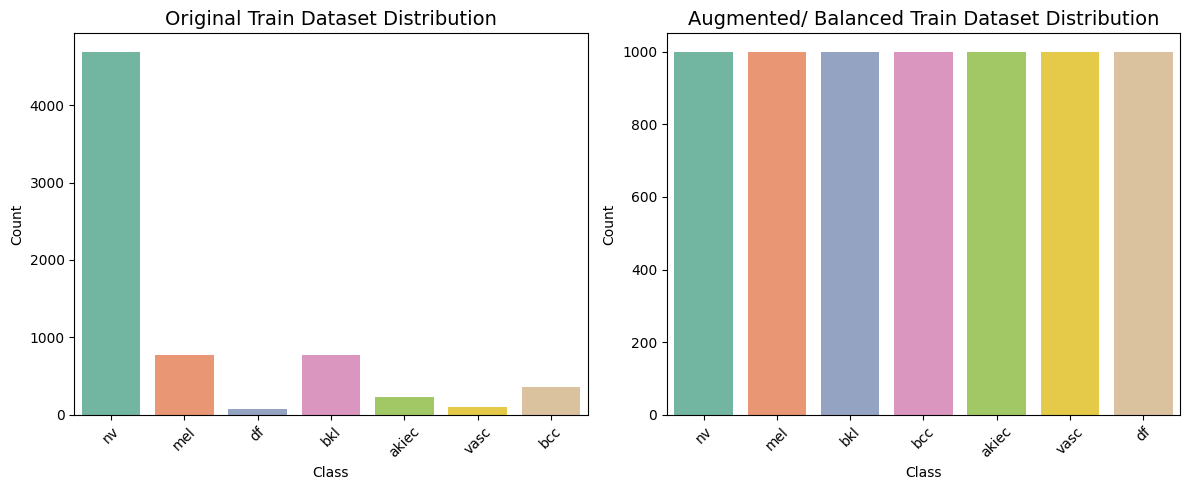

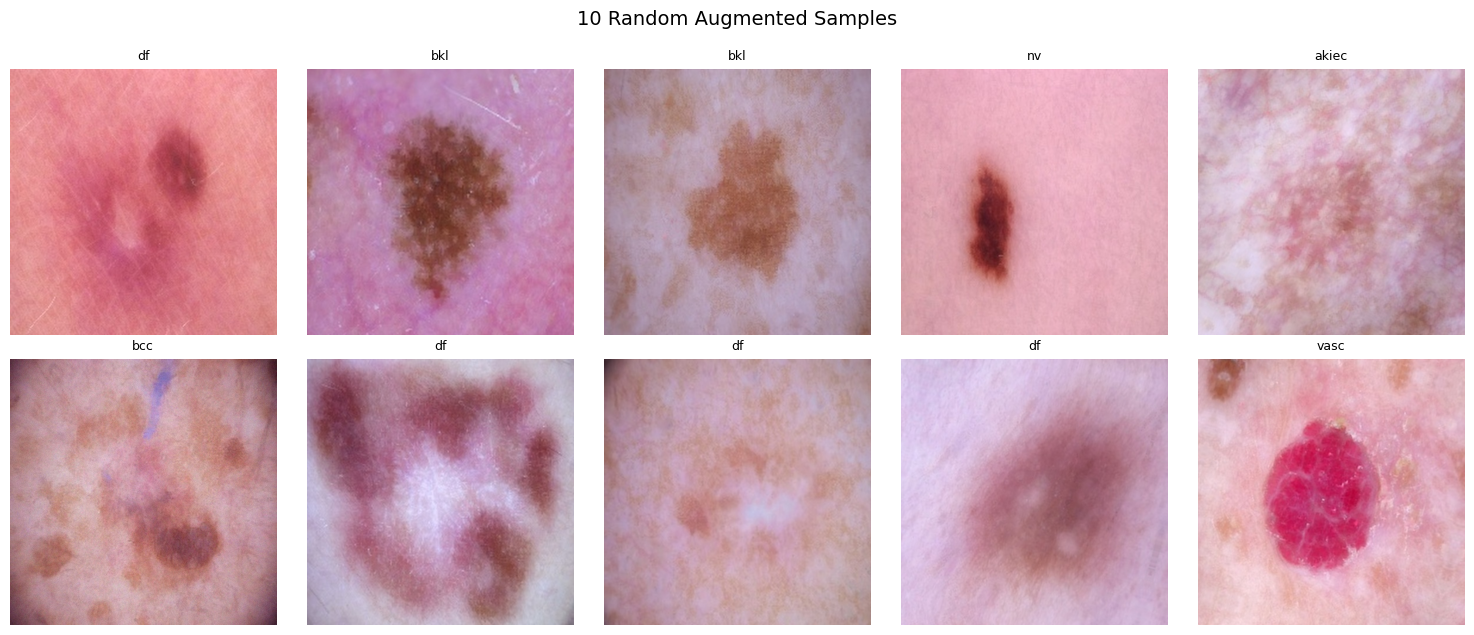

In [12]:
# -------------------------------
# 1. Plot original vs balanced class distribution
# -------------------------------
plt.figure(figsize=(12,5))

# Original train distribution
plt.subplot(1,2,1)
sns.countplot(x='label', data=train_df, palette='Set2')
plt.title("Original Train Dataset Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Balanced (augmented) train distribution
plt.subplot(1,2,2)
sns.countplot(x='label', data=balanced_train_df, palette='Set2')
plt.title("Augmented/ Balanced Train Dataset Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

import random

# -------------------------------
# Show 10 random augmented samples
# -------------------------------
sampled_df = balanced_train_df.sample(n=10, random_state=42)

plt.figure(figsize=(15, 6))

for idx, row in enumerate(sampled_df.itertuples()):
    img = cv2.imread(row.path)  
    img = cv2.cvtColor(cv2.resize(img, (456,456)), cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{row.label}", fontsize=9)

plt.tight_layout()
plt.suptitle("10 Random Augmented Samples", y=1.05, fontsize=14)
plt.show()


In [13]:
print(balanced_train_df.groupby("label").size())

label
akiec    1000
bcc      1000
bkl      1000
df       1000
mel      1000
nv       1000
vasc     1000
dtype: int64


# **One-hot encode the labels And Data Generators (for categorical classification)**

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

IMAGE_SIZE = 456   # EfficientNet default input size
BATCH_SIZE = 32

# -----------------------
# Train generator (no augmentation)
# -----------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=balanced_train_df,
    x_col="path",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

# -----------------------
# Validation generator (no augmentation, only preprocess)
# -----------------------
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="processed_path",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# -----------------------
# Test generator (no augmentation, only preprocess)
# -----------------------
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="processed_path",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# -----------------------
# Debug Info
# -----------------------
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Test samples:", test_generator.samples)
print("Classes:", train_generator.class_indices)


Found 7000 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
Found 2004 validated image filenames belonging to 7 classes.
Train samples: 7000
Validation samples: 1001
Test samples: 2004
Classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


# **Build and compile the EfficientNetB5 model**

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# ------------------------
# Custom Focal Loss
# ------------------------
def categorical_focal_loss(gamma=3.0, alpha=0.5):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        prob = tf.reduce_sum(y_true * y_pred, axis=-1)
        return alpha * (1 - prob) ** gamma * cross_entropy
    return loss

# ------------------------
# Model Builder
# ------------------------
def build_single_model(base_model, num_classes=7):
    x = GlobalAveragePooling2D()(base_model.output)   
    x = Dense(512, activation="swish", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="swish", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="swish", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=output)

# ------------------------
# Single EfficientNetB5 Model
# ------------------------
def build_efficientnetb5(num_classes=7, IMAGE_SIZE=456):
    base_b5 = EfficientNetB5(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Fine-tune some layers
    for layer in base_b5.layers[:200]:
        layer.trainable = False
    for layer in base_b5.layers[200:]:
        layer.trainable = True

    model = build_single_model(base_b5, num_classes)
    return model

# ------------------------
# Instantiate & Compile
# ------------------------
IMAGE_SIZE = 456
model = build_efficientnetb5(num_classes=7, IMAGE_SIZE=IMAGE_SIZE)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=categorical_focal_loss(gamma=3.0, alpha=0.5),
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top3_acc"),
    ]
)

model.summary()


115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 456, 456, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 456, 456, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 456, 456, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 456, 456, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 457, 457, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 228, 228, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 228, 228, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 228, 228, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 228, 228, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 228, 228, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 228, 228, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 29,731,326 (113.42 MB)

 Trainable params: 29,061,959 (110.86 MB)

 Non-trainable params: 669,367 (2.55 MB)

# **Train the model**

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2,min_lr=1e-7)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 631s 2s/step - accuracy: 0.1700 - auc: 0.5404 - loss: 1.2042 - top3_acc: 0.4717 - val_accuracy: 0.4545 - val_auc: 0.8082 - val_loss: 0.5513 - val_top3_acc: 0.8312 - learning_rate: 1.0000e-05
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.2644 - auc: 0.6488 - loss: 0.9663 - top3_acc: 0.6050 - val_accuracy: 0.6154 - val_auc: 0.8873 - val_loss: 0.4207 - val_top3_acc: 0.8631 - learning_rate: 1.0000e-05
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.3513 - auc: 0.7286 - loss: 0.8091 - top3_acc: 0.7007 - val_accuracy: 0.6503 - val_auc: 0.9135 - val_loss: 0.3917 - val_top3_acc: 0.8911 - learning_rate: 1.0000e-05
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.4268 - auc: 0.7872 - loss: 0.6897 - top3_acc: 0.7577 - val_accuracy: 0.6643 - val_auc: 0.9216 - val_loss: 0.3836 - val_top3_acc: 0.8961 - learning_rate: 1.0000e-05
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.4718 - au

In [17]:
# Example: Find epoch with the highest validation accuracy
best_epoch = np.argmax(history.history['accuracy']) + 1
best_acc = history.history['accuracy'][best_epoch - 1]

print(f"Best Epoch: {best_epoch}")
print(f"Accuracy at Best Epoch: {best_acc:.4f}")

Best Epoch: 28
Accuracy at Best Epoch: 0.8639


In [18]:
import zipfile, os

model.save("efficientnetb5.h5")

with zipfile.ZipFile("efficientnetb5.zip", "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("efficientnetb5.h5")

# **Plot Training History (Accuracy & Loss)**

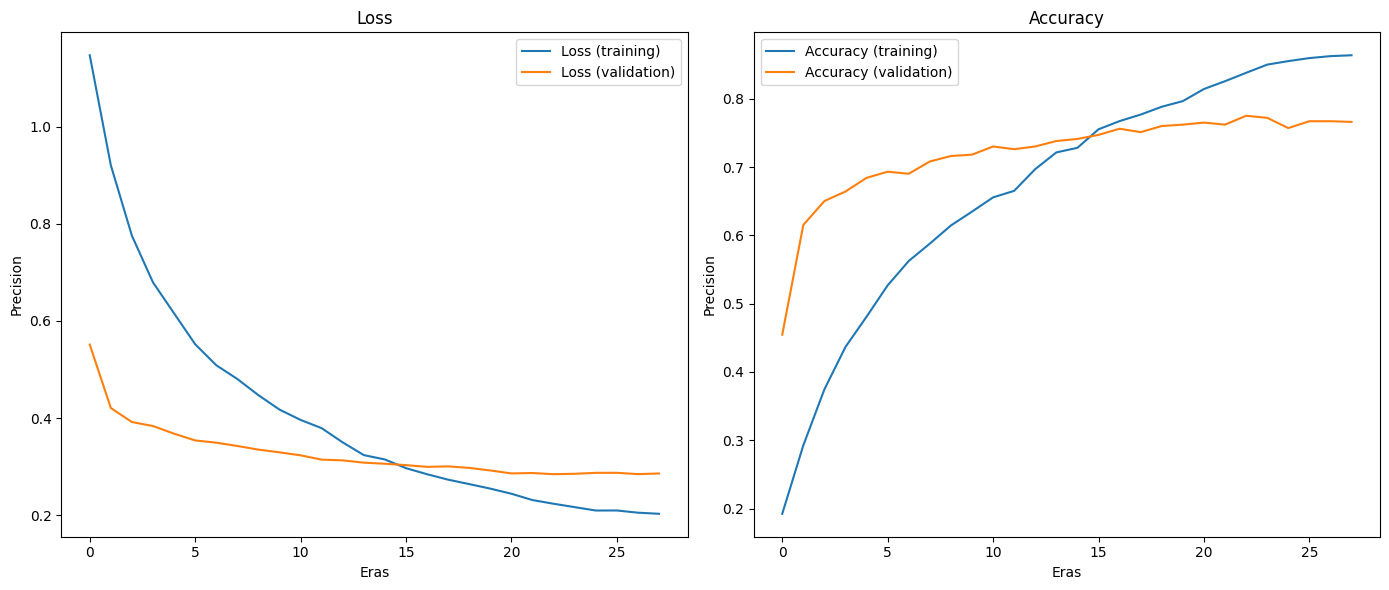

In [19]:
# Training curve
plt.figure(figsize=(14, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Loss')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

# Precision curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (training)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.title('Accuracy')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


# **Evaluate the Model on Test Data**

In [20]:
results = model.evaluate(test_generator)
print(dict(zip(model.metrics_names, results)))


63/63 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7966 - auc: 0.9708 - loss: 0.2740 - top3_acc: 0.9659
{'loss': 0.280386745929718, 'compile_metrics': 0.7719560861587524}


# **Confusion Metrix**

63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 811ms/step
Classification Report:

              precision    recall  f1-score   support

       akiec       0.65      0.57      0.61        65
         bcc       0.55      0.79      0.65       103
         bkl       0.50      0.75      0.60       220
          df       0.53      0.73      0.62        22
         mel       0.48      0.43      0.45       223
          nv       0.93      0.84      0.88      1342
        vasc       0.70      0.90      0.79        29

    accuracy                           0.77      2004
   macro avg       0.62      0.71      0.66      2004
weighted avg       0.80      0.77      0.78      2004



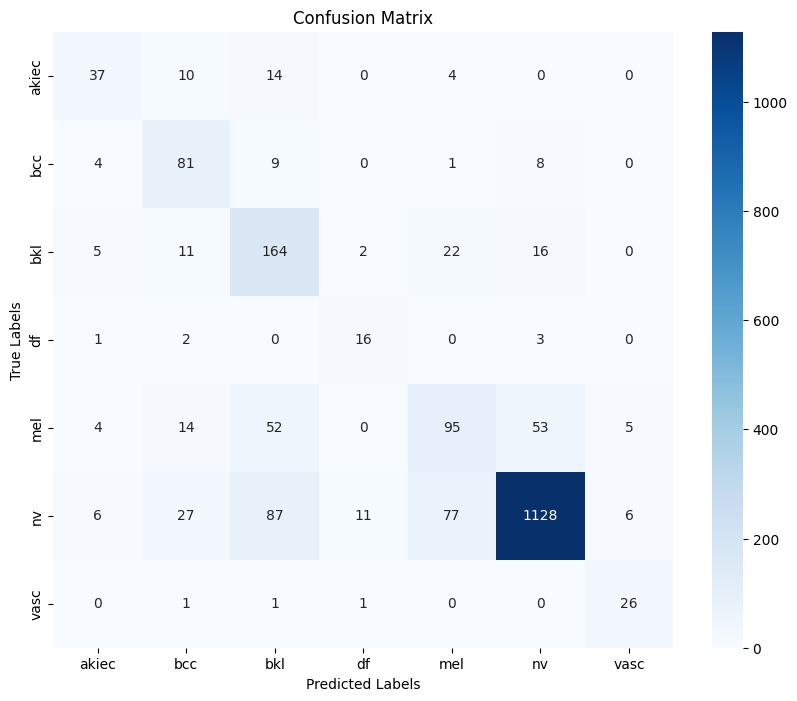

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Step 1: Get predicted probabilities
y_prob =  model.predict(test_generator)

# Step 2: Convert probabilities to predicted class indices
y_pred = np.argmax(y_prob, axis=1)

# Step 3: Get true labels from the generator
y_true = test_generator.classes

# Step 4: Get label names from generator
labels = list(test_generator.class_indices.keys())

# Step 5: Print Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Step 6: Plot Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

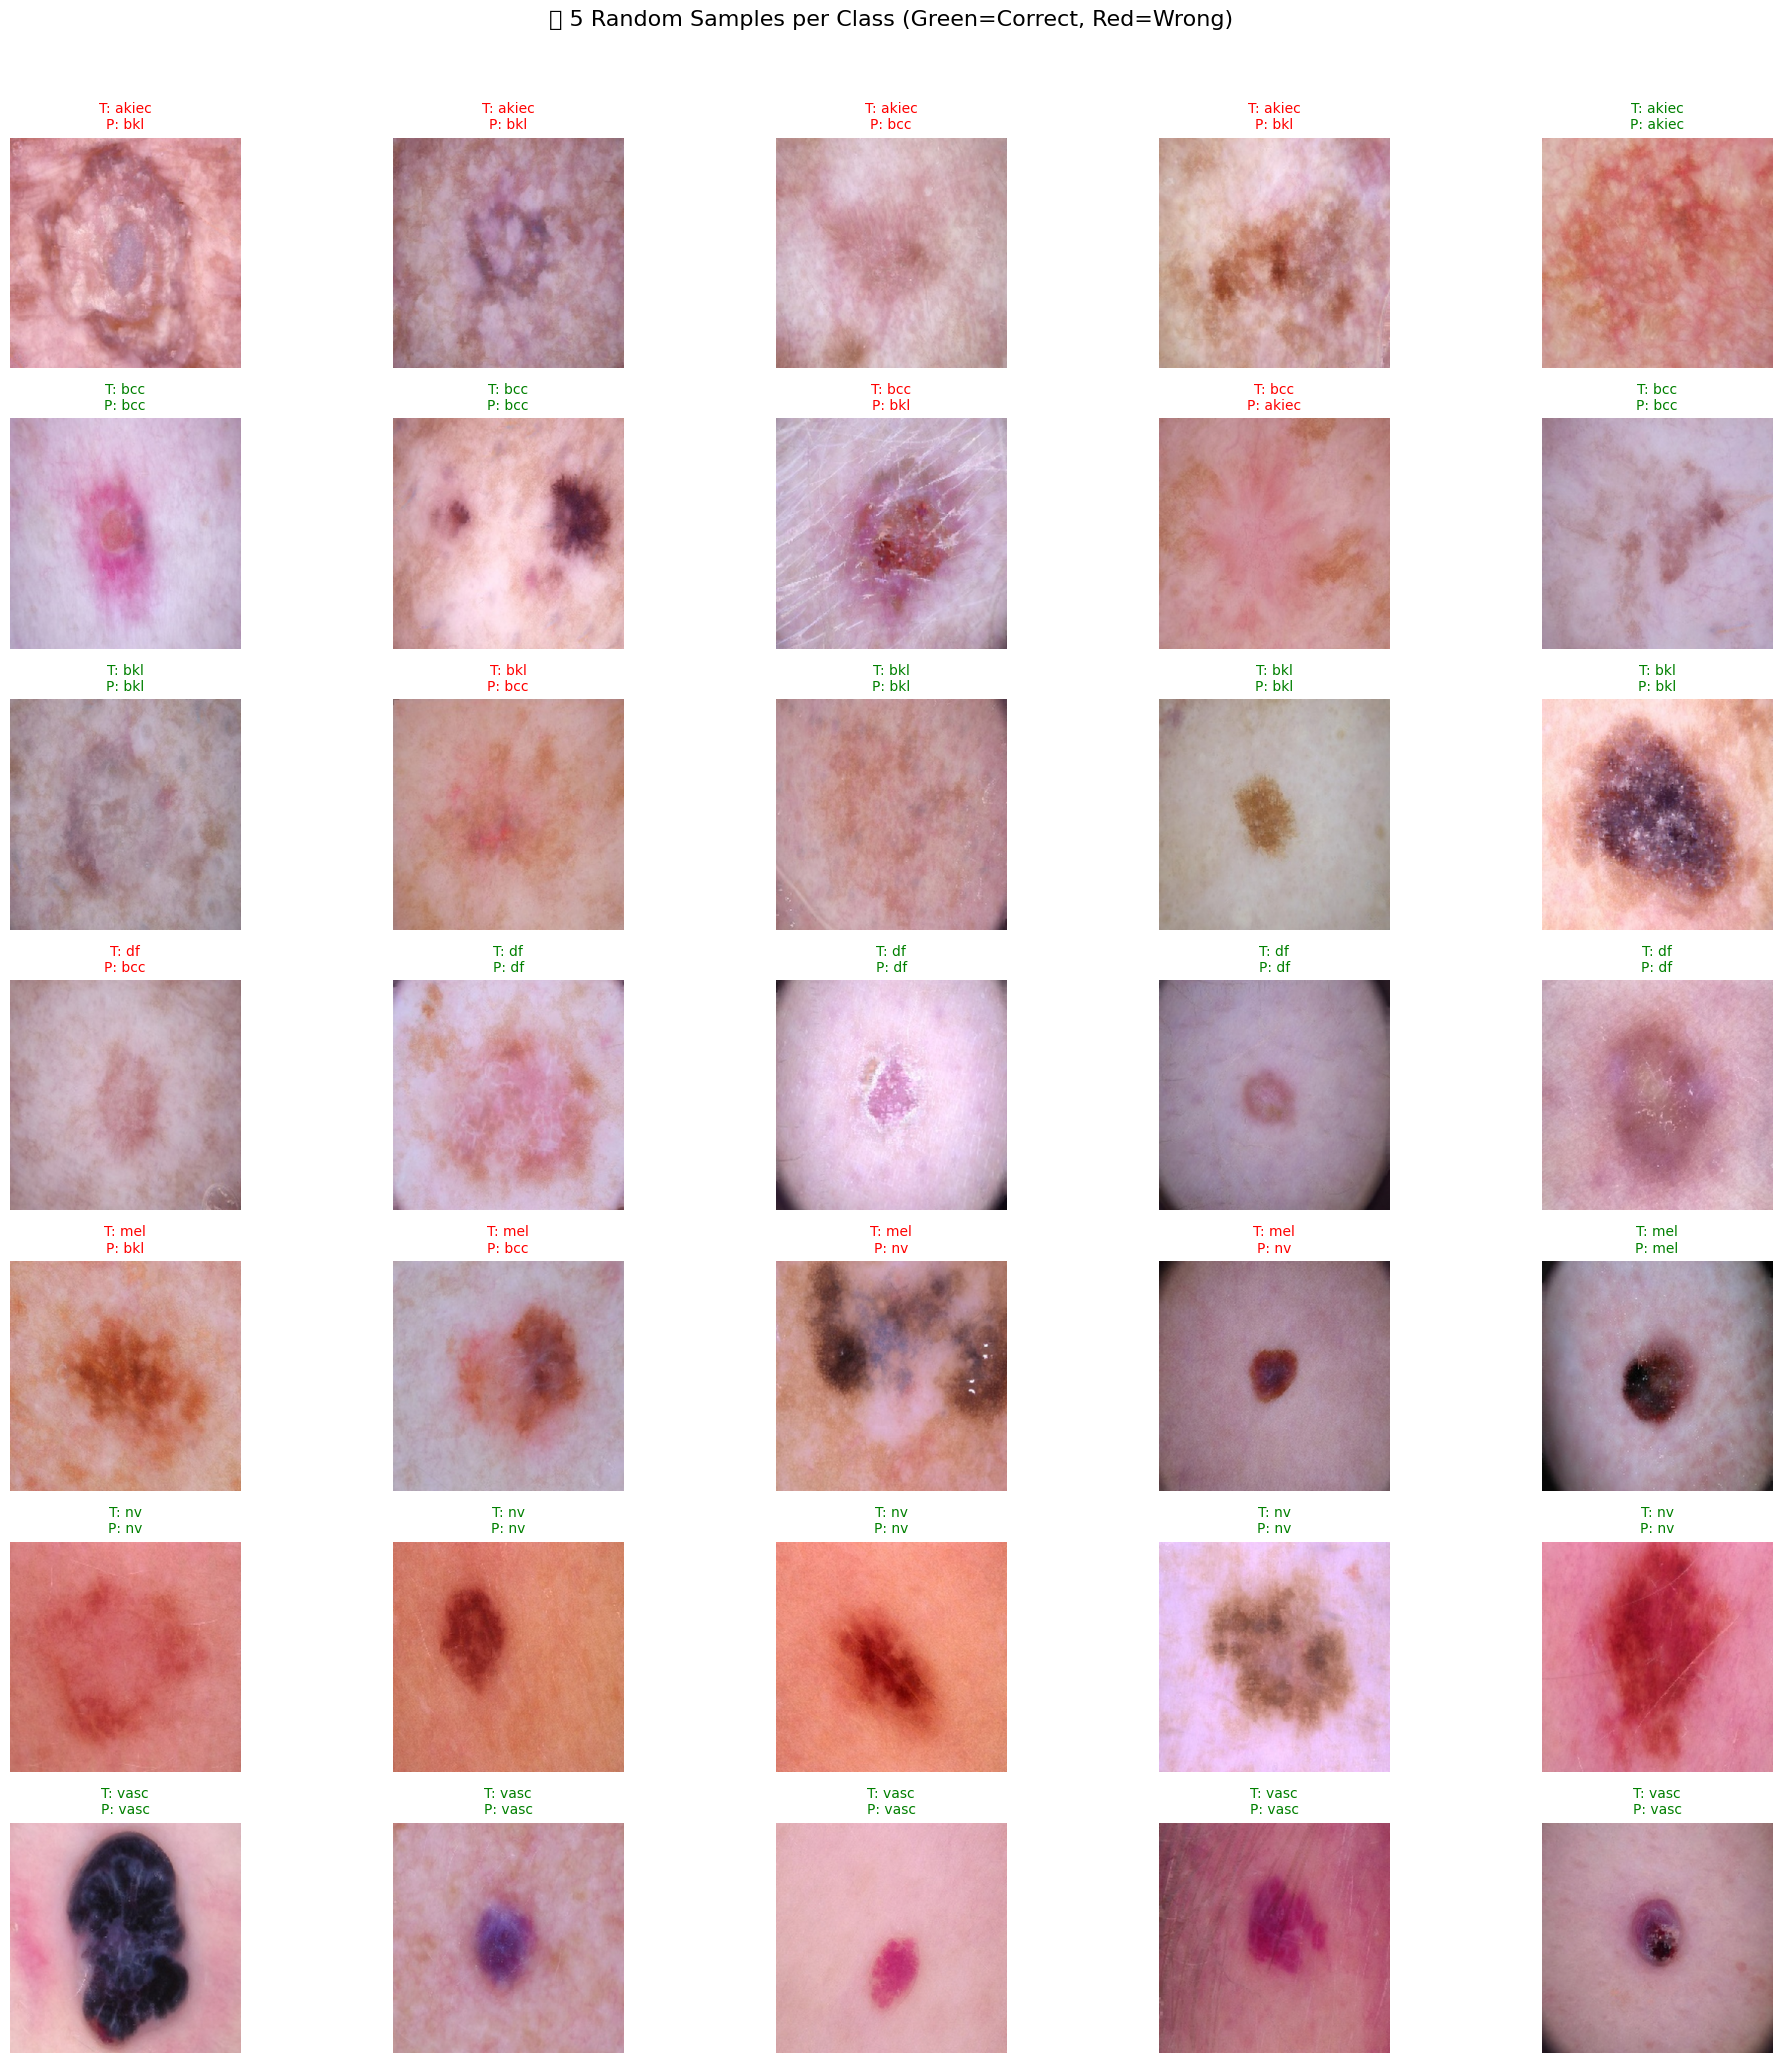

In [22]:
import matplotlib.pyplot as plt
import random
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Setup ---
num_samples_per_class = 5  # how many images per class
unique_classes = np.unique(y_true)

# --- Collect 5 random indices per class ---
selected_indices = []
for cls in unique_classes:
    cls_indices = np.where(y_true == cls)[0]
    cls_sample = random.sample(list(cls_indices), min(num_samples_per_class, len(cls_indices)))
    selected_indices.extend(cls_sample)

# --- Plot all selected samples ---
plt.figure(figsize=(20, len(unique_classes) * 3))

for i, idx in enumerate(selected_indices):
    img_path = test_generator.filepaths[idx]
    img = image.load_img(img_path, target_size=(380, 380))
    img_array = image.img_to_array(img) / 255.0

    true_class = labels[y_true[idx]]
    pred_class = labels[y_pred[idx]]
    color = "green" if true_class == pred_class else "red"

    plt.subplot(len(unique_classes), num_samples_per_class, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"T: {true_class}\nP: {pred_class}", color=color, fontsize=10)

plt.suptitle("🎯 5 Random Samples per Class (Green=Correct, Red=Wrong)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
